# Data Analysis for LR Estimation Project

This workbook contains code to analyze the performance of the LR estimator against the reported LRs from theNNT.com

Requires that estimates have been generated and formatted as performed by the 'lr_scraper_estimator.ipynb' workbook

#### Read in the estimates

In [1]:
import numpy as np
import pandas as pd
from statsmodels.graphics.agreement import mean_diff_plot
import scienceplots
from datetime import datetime
import pingouin as pg
import os
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import blended_transform_factory

from pathlib import Path
from datetime import date
import os

WORKING_DIR = Path.cwd()  # or Path("/path/to/project")
OUTPUT_DIR = WORKING_DIR / "results" / date.today().strftime("%Y-%m-%d")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
print("Outputs ->", OUTPUT_DIR)

file_path = os.path.join(WORKING_DIR, 'NNT_LRs_08-26-2025.xlsx')
use_columns = ['lr_reported', 'lr_gpt-4o-2024-11-20', 'lr_o3-2025-04-16', 'lr_gpt-5', 'Feature Type'] 
df = pd.read_excel(file_path, sheet_name='Master', usecols=use_columns)

print(df.head())

Outputs -> /Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/results/2025-08-27
   lr_reported  lr_gpt-5  lr_gpt-4o-2024-11-20  lr_o3-2025-04-16  \
0    34.400000     35.00                 20.00             30.00   
1     0.010000      0.02                  0.25              0.07   
2    17.435596     14.00                 11.00             20.00   
3    14.000000      7.00                 14.00              3.00   
4     6.400000      3.30                  6.50              4.00   

      Feature Type  
0  Imaging finding  
1  Imaging finding  
2          History  
3     Sign/symptom  
4     Sign/symptom  


#### Data Cleaning and Transforms

- First, ensure that there are no missing values
- then create log transformed versions of each LR (aka "Weights of Evidence") for subsequent analysis 
- then generate qualitative descriptions of all of the LRs 

In [2]:
# 1) pick the lr* columns that exist in df
cols_to_log = [c for c in use_columns if isinstance(c, str) and c.startswith('lr') and c in df.columns]

# 2) coerce to numeric in-place (handles "1,234", spaces, and Unicode minus)
def _to_num(s: pd.Series) -> pd.Series:
    s = s.replace({r'[,\s]': '', '−': '-'}, regex=True)   # strip commas/spaces; normalize minus
    return pd.to_numeric(s, errors='coerce')

df[cols_to_log] = df[cols_to_log].apply(_to_num).replace([np.inf, -np.inf], np.nan)

# 3) optional: identify any non-finite or non-positive values before logging
nonfinite_rows = ~np.isfinite(df[cols_to_log]).all(axis=1)
nonpos_cols = df[cols_to_log].le(0).any()

# 4) create logs where valid
for col in cols_to_log:
    # if you want to strictly avoid taking log of invalids, do it row-wise with where():
    df[f'ln_{col}'] = np.log(df[col].where(df[col] > 0))

# Check for any non-positive values
mask = df[cols_to_log].le(0)

if mask.any().any():  # if any True values exist
    bad_col = mask.any().idxmax()                  # first column with a problem
    bad_val = df.loc[mask[bad_col], bad_col].iloc[0]  # first offending value
    bad_idx = df.loc[mask[bad_col], :].index[0]       # its row index
    raise ValueError(
        f"Column '{bad_col}' contains non-positive value {bad_val} at row {bad_idx}; cannot take log."
    )

In [3]:
# make sure Feature Type is a string and handle missing values
ft = df["Feature Type"].fillna("").astype(str)

df["test_results"]  = ft.str.contains(r"test",       case=False, na=False).astype(int)
df["imaging"]       = ft.str.contains(r"imaging",    case=False, na=False).astype(int)
df["history"]       = ft.str.contains(r"history",    case=False, na=False).astype(int)
df["sign_symptom"]  = ft.str.contains(r"sign|symptom", case=False, na=False).astype(int)
df["diagnosis"]     = ft.str.contains(r"diagnosis",  case=False, na=False).astype(int)

Qualitative label generation - according to Users Guide to the Medical Literature strength of evidence classification

In [4]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

# 1) Single source‑of‑truth for order
_ORD = [
    "Strong Negative",
    "Moderate Negative",
    "Weak Negative",
    "Negligible",
    "Weak Positive",
    "Moderate Positive",
    "Strong Positive",
]
ORD_DTYPE = CategoricalDtype(categories=_ORD, ordered=True)

# 2) Robust mapper → ordered categorical with the *same* dtype
def gen_qual_label(lr_series: pd.Series, dtype: CategoricalDtype = ORD_DTYPE) -> pd.Series:
    """Map positive LR values to ordinal bands; invalid/non‑positive → NaN."""
    lr = pd.to_numeric(lr_series, errors="coerce")
    lr = lr.where(lr > 0)  # enforce LR > 0; otherwise NaN

    conds = [
        (lr <= 0.10),                               # Strong Negative
        (lr > 0.10) & (lr <= 0.20),                 # Moderate Negative
        (lr > 0.20) & (lr <  0.50),                 # Weak Negative
        (lr >= 0.50) & (lr <  2.00),                # Negligible
        (lr >= 2.00) & (lr <  5.00),                # Weak Positive
        (lr >= 5.00) & (lr < 10.00),                # Moderate Positive
        (lr >= 10.00),                              # Strong Positive
    ]

    labels = np.select(conds, _ORD, default=None)   # object array (None → NaN)
    out = pd.Series(labels, index=lr_series.index, dtype="object").astype(dtype)
    return out

In [5]:
# Reference labels
df["lr_reported_qual"] = gen_qual_label(df["lr_reported"])

# All model‑derived labels use the *same* dtype
for c in df.columns:
    if c.startswith("lr_"):  # numeric LR columns
        q = "qual_" + c
        df[q] = gen_qual_label(df[c])          # creates with ORD_DTYPE
        # If some existed already, force‑cast to the same dtype:
        df[q] = df[q].astype(ORD_DTYPE)

# Absolute counts and percentages (keep category order; include missing if desired)
# value_counts in ordinal order
freq = df["lr_reported_qual"].value_counts(sort=False, dropna=False)
pct  = df["lr_reported_qual"].value_counts(sort=False, normalize=True, dropna=False) * 100

print("Counts of qualitative LR descriptions")
print(freq)
print("\n\n Percentage of qualitative LR descriptions")
print(pct.round(2))

Counts of qualitative LR descriptions
lr_reported_qual
Strong Negative       17
Moderate Negative     22
Weak Negative         60
Negligible           400
Weak Positive        120
Moderate Positive     52
Strong Positive       29
Name: count, dtype: int64


 Percentage of qualitative LR descriptions
lr_reported_qual
Strong Negative       2.43
Moderate Negative     3.14
Weak Negative         8.57
Negligible           57.14
Weak Positive        17.14
Moderate Positive     7.43
Strong Positive       4.14
Name: proportion, dtype: float64


#### Visualize the distribution of reported LR strengths

In [6]:
# ------------------------------------------------------------------
# Summary statistics for reported likelihood ratios (LR_reported)
# ------------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import gmean 

# Vector of LR values (already on LR, not ln) ----------------------
lr_reported = df["lr_reported"].dropna().values 

# Compute key summary stats ----------------------------------------
q05, q25, q50, q75, q95 = np.percentile(lr_reported, [5, 25, 50, 75, 95])

summary = pd.Series({
    "count"       : lr_reported.size,
    "geometric mean"  : gmean(lr_reported),
    "5th percentile"  : q05,
    "25th percentile" : q25,
    "50th percentile" : q50,
    "75th percentile" : q75,
    "95th percentile" : q95,
    "min"         : lr_reported.min(),
    "max"         : lr_reported.max(),
})

# Print in a tidy format -------------------------------------------
print(summary.to_string(float_format="%.3f"))

count             700.000
geometric mean      1.206
5th percentile      0.190
25th percentile     0.700
50th percentile     1.000
75th percentile     2.200
95th percentile     7.905
min                 0.010
max               145.894


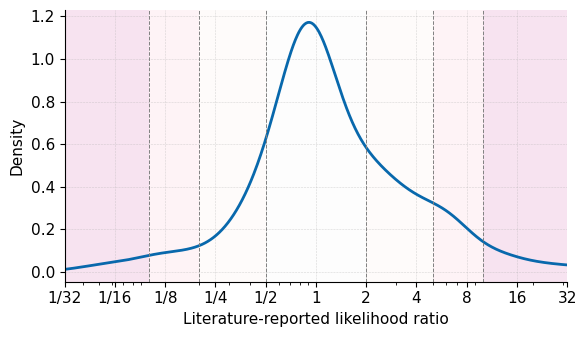

In [7]:
# --- KDE plot ----------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from scipy.stats import gaussian_kde

plt.rcParams.update({"font.size": 11, "axes.spines.right": False,
                     "axes.spines.top": False})

lr = np.exp(df["ln_lr_reported"].dropna().values)
log_lr = np.log10(lr)
kde = gaussian_kde(log_lr, bw_method="scott")

low, high = 1/32, 32
x_log  = np.linspace(np.log10(low), np.log10(high), 700)
pdf    = kde(x_log)
pdf   /= np.trapz(pdf, x_log)

lr_x = 10**x_log

# qualitative‑band shading (follows JAMA categorization)
cuts = [0.1, 0.2, 0.5, 2, 5, 10]
bands = [(low, 0.1), (0.1,0.2), (0.2,0.5), (0.5,2),
         (2,5), (5,10), (10,high)]
light = "#fde0dd"; mid = "#fa9fb5"; dark = "#c51b8a"
band_cols = [dark, mid, light, "#f0f0f0", light, mid, dark]

fig, ax = plt.subplots(figsize=(6, 3.5))

for (a, b), col in zip(bands, band_cols):
    ax.axvspan(a, b, color=col, alpha=0.12, lw=0)

ax.plot(lr_x, pdf, lw=2.0, color="#0868ac")        # curve only

# log ticks as fractions ---------------------------------------------------
ticks = [1/32, 1/16, 1/8, 1/4, 1/2, 1, 2, 4, 8, 16, 32]
tick_labels = [("1/"+str(int(1/t))) if t < 1 else f"{int(t)}" for t in ticks]

ax.set_xscale("log")
ax.set_xlim(low, high)
ax.set_xlabel("Literature-reported likelihood ratio")
ax.set_ylabel("Density")

ax.xaxis.set_major_locator(FixedLocator(ticks))
ax.xaxis.set_major_formatter(FixedFormatter(tick_labels))

# vertical reference lines only -------------------------------------------
for c in cuts:
    ax.axvline(c, ls="--", lw=0.7, color="grey")

ax.grid(which="major", ls="--", lw=0.4, alpha=0.5)
ax.grid(which="minor", lw=0, alpha=0)

fig.tight_layout()

fig.savefig(os.path.join(OUTPUT_DIR, 'Figure 1 - lr_reported_kde.pdf'),
            dpi=600, bbox_inches="tight")

# Agreement between Literature-reported LRs and LLM-estimated LRs 

All analyses are done on the log scale because LRs are inherently ratio metrics -> linear on the log scale. 

Bland-altman on the Log Scale assesses for the "x-fold" limits of agreements (ie. ratio of agreement)

## Main Figure: 

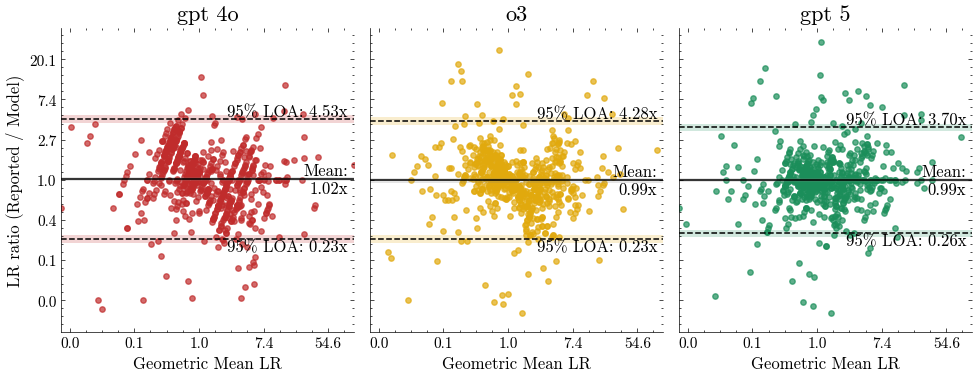

In [8]:
plt.style.use(["science", "no-latex"])

# ── helper: convert ln‑ticks to LR values ────────────────────────────
def exp_fmt(x, _):
    return f"{np.exp(x):.1f}"
fmt = FuncFormatter(exp_fmt)

# ── panel specification ────────(manual)──────────────────────────────
panels = [
    ("gpt 4o", df["ln_lr_gpt-4o-2024-11-20"], "#c02c2c"),  # red
    ("o3",      df["ln_lr_o3-2025-04-16"],      "#e1a90d"),  # amber
    ("gpt 5", df["ln_lr_gpt-5"],     "#1b8e5a"),  # emerald
]
ln_ref = df["ln_lr_reported"]

# ── global limits (across all three models) ─────────────────────────
means = [(ln_ref + m) / 2 for _, m, _ in panels]
diffs = [ln_ref - m       for _, m, _ in panels]
xlim  = (np.concatenate(means).min(), np.concatenate(means).max())
ylim  = (-1.1*np.abs(np.concatenate(diffs)).max(),
          1.1*np.abs(np.concatenate(diffs)).max())

# ── figure scaffold ─────────────────────────────────────────────────
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10, 4))

for ax, (title, ln_model, colour) in zip(axes, panels):

    # Draw Bland Altman panel with Pingouin
    pg.plot_blandaltman(
        ln_ref, ln_model,
        ax=ax,
        marker="o", s=15, alpha=0.7, color=colour
    )

    # Re‑style the three horizontal lines
    ax.lines[0].set(color="black", lw=1.1, ls="-")   # mean
    for ln in ax.lines[1:]:
        ln.set(color="black", lw=1.1, ls="--")       # LoA

    # Remove Pingouin's default annotations
    for t in list(ax.texts):
        t.remove()

    # Custom anti‑logged labels
    ln_diff = ln_ref - ln_model
    mu      = ln_diff.mean()
    sd      = ln_diff.std(ddof=1)
    up, lo  = mu + 1.96*sd, mu - 1.96*sd

    trans = blended_transform_factory(ax.transAxes, ax.transData)
    ax.text(0.98, mu, f"Mean:\n{np.exp(mu):.2f}x",
            transform=trans, ha="right", va="center", fontsize=12)
    ax.text(0.98, up, f"95% LOA: {np.exp(up):.2f}x",
            transform=trans, ha="right", va="bottom", fontsize=12)
    ax.text(0.98, lo, f"95% LOA: {np.exp(lo):.2f}x",
            transform=trans, ha="right", va="top", fontsize=12)

    # Axis limits and formatting
    ax.set_title(title, fontsize=16)
    ax.set_xlim(xlim); ax.set_ylim(ylim)
    ax.xaxis.set_major_formatter(fmt)
    ax.yaxis.set_major_formatter(fmt)
    ax.set_xlabel("Geometric Mean LR", fontsize=12)
    if ax is axes[0]:
        ax.set_ylabel("LR ratio (Reported / Model)", fontsize=12)

# Outer‑label housekeeping
for ax in axes[1:]:
    ax.set_ylabel("")
axes[-1].set_xlabel("Geometric Mean LR", fontsize=12)  # rightmost already set; keeps symmetry

fig.tight_layout()
fig.savefig(os.path.join(OUTPUT_DIR, "Figure 2 - bland_altman_3_panel.pdf"),
            format="pdf", bbox_inches="tight")

### Subgroup Figures

Current Subgroups: 

- by categorization of the finding
- by supporting or not evidence (LR above or below 1)

All subgroups are plotted for each model.

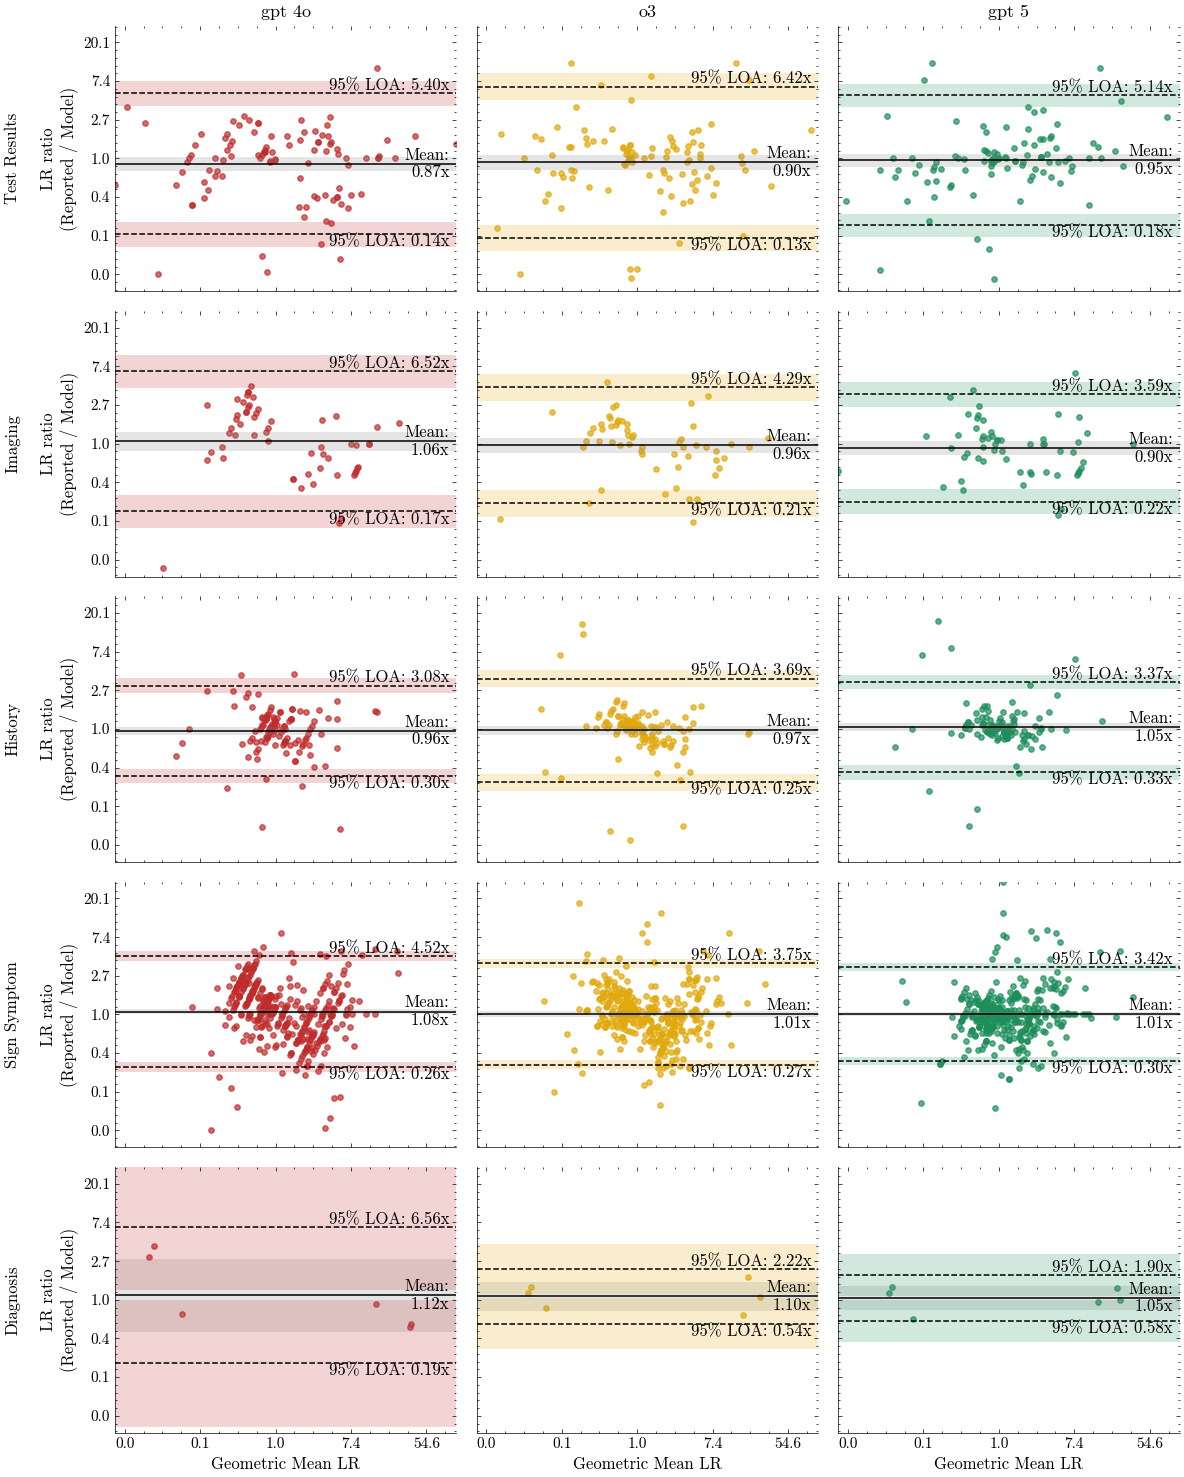

In [9]:
"""
Figure 3a - Finding type x model Bland-Altman Plots

5x3 Bland-Altman grid 
• Rows = finding types              (test/imaging/history/signs/diagnosis)
• Cols = LLM models                 (4o, o3, 5)
• Log the data internally; axes and labels shown as LR
• Shared limits, SciencePlots styling, colour-coded dots
"""

plt.style.use(["science", "no-latex"])

# ── helper to show LR values on ln axis ─────────────────────────────
def exp_fmt(x, _):
    return f"{np.exp(x):.1f}"
fmt = FuncFormatter(exp_fmt)

# ── model columns & colours (3 columns) ────────────────────────────
MODELS = [
    ("gpt 4o", df["ln_lr_gpt-4o-2024-11-20"], "#c02c2c"),  # red
    ("o3",      df["ln_lr_o3-2025-04-16"],      "#e1a90d"),  # amber
    ("gpt 5", df["ln_lr_gpt-5"],     "#1b8e5a"),  # emerald
]

# ── feature‑type rows (5 rows) ─────────────────────────────────────
ROWS = ["test_results", "imaging", "history", "sign_symptom", "diagnosis"]

ln_ref = df["ln_lr_reported"]

# ── global x/y limits across every (row × model) slice ─────────────
means_all, diffs_all = [], []
for _, ln_mod, _ in MODELS:
    for row in ROWS:
        m = df[row] == 1
        if m.any():
            means_all.append((ln_ref[m] + ln_mod[m]) / 2)
            diffs_all.append(ln_ref[m] - ln_mod[m])

xlim = (np.concatenate(means_all).min(), np.concatenate(means_all).max())
ylim = (-1.0*np.abs(np.concatenate(diffs_all)).max(),
         1.0*np.abs(np.concatenate(diffs_all)).max())

# ── build the 5×3 grid ─────────────────────────────────────────────
fig, axes = plt.subplots(len(ROWS), len(MODELS),
                         sharex=True, sharey=True,
                         figsize=(12, 15))

for r, row in enumerate(ROWS):
    mask_row = df[row] == 1
    row_title = row.replace("_", " ").title()

    for c, (model_name, ln_mod, colour) in enumerate(MODELS):
        ax = axes[r, c]
        if not mask_row.any():
            ax.axis("off")
            ax.set_title(f"{row_title}\n(no rows)")
            continue

        # ── Bland‑Altman panel ────────────────────────────
        pg.plot_blandaltman(
            ln_ref[mask_row], ln_mod[mask_row],
            ax=ax,
            marker="o", s=15, alpha=0.7, color=colour
        )

        # Re‑style mean and LoA lines added by Pingouin
        ax.lines[0].set(color="black", lw=1.1, ls="-")   # mean
        for ln in ax.lines[1:]:
            ln.set(color="black", lw=1.1, ls="--")       # LoA

        # Remove Pingouin’s default labels
        for t in list(ax.texts):
            t.remove()

        # ── custom anti‑logged μ and LoA labels ───────────────────
        ln_diff = ln_ref[mask_row] - ln_mod[mask_row]
        mu  = ln_diff.mean()
        sd  = ln_diff.std(ddof=1)
        up, lo = mu + 1.96*sd, mu - 1.96*sd

        trans = blended_transform_factory(ax.transAxes, ax.transData)
        ax.text(0.98, mu, f"Mean:\n{np.exp(mu):.2f}x",
                transform=trans, ha="right", va="center", fontsize=12)
        ax.text(0.98, up, f"95% LOA: {np.exp(up):.2f}x",
                transform=trans, ha="right", va="bottom", fontsize=12)
        ax.text(0.98, lo, f"95% LOA: {np.exp(lo):.2f}x",
                transform=trans, ha="right", va="top", fontsize=12)

        # ── axes & ticks ─────────────────────────────────────────
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

        # column headers & row labels
        if r == 0:
            ax.set_title(model_name, fontsize=13, pad=6)
        if c == 0:
            ax.set_ylabel(f"{row_title}\n\nLR ratio\n(Reported / Model)",
                fontsize=12
            )

        if r == len(ROWS) - 1:
            ax.set_xlabel("Geometric Mean LR", fontsize=12)

# keep outer tick labels only
for ax in axes.flat:
    ax.label_outer()

fig.tight_layout(h_pad=1.3, w_pad=1.2)
fig.savefig(os.path.join(OUTPUT_DIR, "Figure 3a - Finding type bland altman grid.pdf"),
            format="pdf", bbox_inches="tight")

[ ] TODO: We could test for differences between all of the different subgroups? might be a bit overwhelming for all the pairwise comparisons, and omnibus test likely to not be informative... so have held off.

### Subgroups by positive (LR reported > 1) vs negative (LR reported < 1) evidence 

Uses similar mechanics

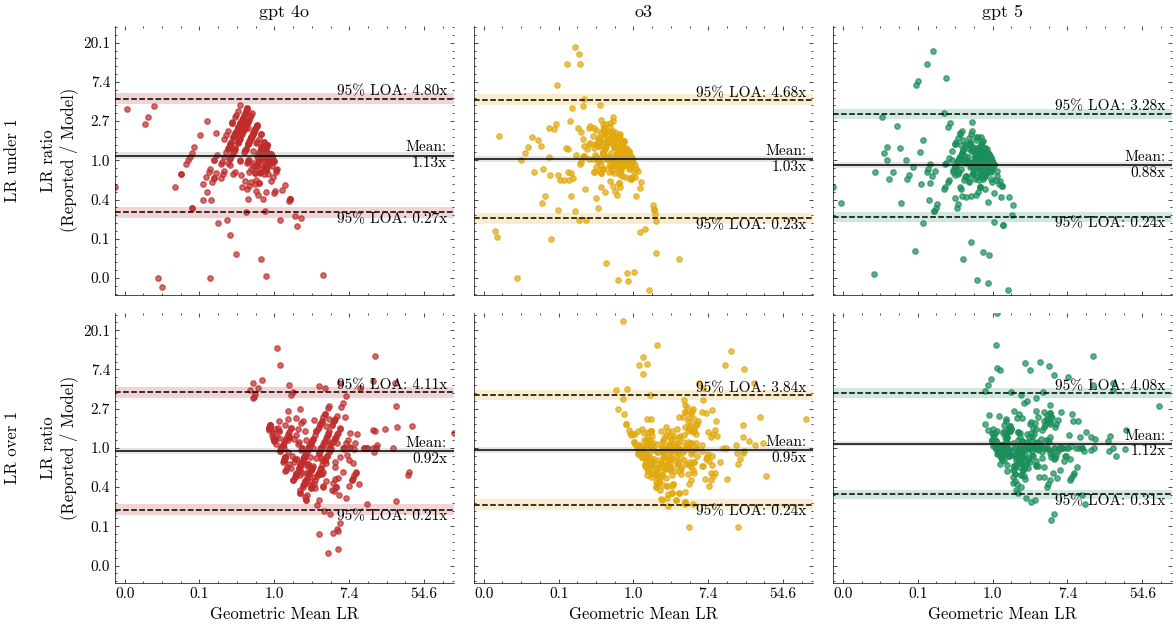

In [10]:
"""
2 x 3 Bland-Altman grid 
• Rows = evidence direction         (LR < 1  vs  LR > 1)
• Cols = LLM model                 
• Natural log data internally; axes and labels shown as LR (anti-logged)
• Shared limits, SciencePlots styling, colour‑coded dots
"""

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.transforms import blended_transform_factory
import pingouin as pg

plt.style.use(["science", "no-latex"])

# ── helper to show LR values on ln axis ───────────────────────────
def exp_fmt(x, _):
    return f"{np.exp(x):.1f}"
fmt = FuncFormatter(exp_fmt)

# ── model columns & colours (3) ───────────────────────────────────
MODELS = [
    ("gpt 4o", df["ln_lr_gpt-4o-2024-11-20"], "#c02c2c"),  # red
    ("o3",      df["ln_lr_o3-2025-04-16"],      "#e1a90d"),  # amber
    ("gpt 5", df["ln_lr_gpt-5"],     "#1b8e5a"),  # emerald
]

ln_ref = df["ln_lr_reported"]

# ── define the two evidence‑direction rows ───────────────────────
ROW_DEFS = [
    ("LR under 1",  ln_ref <  0),   # negative evidence
    ("LR over 1",  ln_ref >  0),   # positive evidence
]

# ── global x/y limits across every (row × model) slice ───────────
means_all, diffs_all = [], []
for _, ln_mod, _ in MODELS:
    for _, mask in ROW_DEFS:
        m = mask & ln_mod.notna()
        if m.any():
            means_all.append((ln_ref[m] + ln_mod[m]) / 2)
            diffs_all.append(ln_ref[m] - ln_mod[m])

xlim = (np.concatenate(means_all).min(), np.concatenate(means_all).max())
ylim = (-1.0 * np.abs(np.concatenate(diffs_all)).max(),
         1.0 * np.abs(np.concatenate(diffs_all)).max())

# ── build the 2×3 grid ───────────────────────────────────────────
fig, axes = plt.subplots(len(ROW_DEFS), len(MODELS),
                         sharex=True, sharey=True,
                         figsize=(12, 6.5))

for r, (row_title, row_mask) in enumerate(ROW_DEFS):
    for c, (model_name, ln_mod, colour) in enumerate(MODELS):
        ax = axes[r, c]
        mask = row_mask & ln_mod.notna()

        if not mask.any():
            ax.axis("off")
            ax.set_title(f"{row_title}\n(no rows)")
            continue

        # ── Pingouin Bland‑Altman panel ───────────────────────────
        pg.plot_blandaltman(
            ln_ref[mask], ln_mod[mask],
            ax=ax,
            marker="o", s=15, alpha=0.7, color=colour
        )

        # Restyle mean and LoA lines
        ax.lines[0].set(color="black", lw=1.1, ls="-")    # mean
        for ln in ax.lines[1:]:
            ln.set(color="black", lw=1.1, ls="--")         # LoA

        # Remove Pingouin’s default text
        for t in list(ax.texts):
            t.remove()

        # ── custom anti‑logged μ and LoA labels ────────────────
        ln_diff = ln_ref[mask] - ln_mod[mask]
        mu  = ln_diff.mean()
        sd  = ln_diff.std(ddof=1)
        up, lo = mu + 1.96*sd, mu - 1.96*sd

        trans = blended_transform_factory(ax.transAxes, ax.transData)
        ax.text(0.98, mu, f"Mean:\n{np.exp(mu):.2f}x",
                transform=trans, ha="right", va="center", fontsize=11)
        ax.text(0.98, up, f"95% LOA: {np.exp(up):.2f}x",
                transform=trans, ha="right", va="bottom", fontsize=11)
        ax.text(0.98, lo, f"95% LOA: {np.exp(lo):.2f}x",
                transform=trans, ha="right", va="top", fontsize=11)

        # ── axis limits & tick format ──────────────────────────
        ax.set_xlim(xlim); ax.set_ylim(ylim)
        ax.xaxis.set_major_formatter(fmt)
        ax.yaxis.set_major_formatter(fmt)

        # headers and labels
        if r == 0:
            ax.set_title(model_name, fontsize=13, pad=6)
        if c == 0:
            ax.set_ylabel(f"{row_title}\n\nLR ratio\n(Reported / Model)",
                          fontsize=12)
        if r == len(ROW_DEFS) - 1:
            ax.set_xlabel("Geometric Mean LR", fontsize=12)

# keep only outer tick labels
for ax in axes.flat:
    ax.label_outer()

fig.tight_layout(h_pad=1.2, w_pad=1.2)
fig.savefig(os.path.join(OUTPUT_DIR, "Figure 3b - LR sign bland altman grid.pdf"),
            format="pdf", bbox_inches="tight")

### Subgroup Tests

Signficant difference between the subgroups? 

- in mean bias (Welch t) 
- limits of agreement width (Levene Test)

note: unpaired, because not the same observations.

In [11]:
# ------------------------------------------------------------------
# Compare bias (Welch t) and spread (Levene) between LR<1 vs LR>1
# for each model. Use scipy.stats versions of these tests
# ------------------------------------------------------------------
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind, levene

# log‑reported LR in dataframe
ln_ref = df["ln_lr_reported"]

# models to evaluate  (label, log‑predicted‑LR column)
MODELS = [
    ("gpt 4o", df["ln_lr_gpt-4o-2024-11-20"]), 
    ("o3",      df["ln_lr_o3-2025-04-16"]),
    ("gpt 5", df["ln_lr_gpt-5"])
]

# sub‑group masks
ROW_DEFS = [
    ("LR < 1",  ln_ref < 0),   # negative evidence
    ("LR > 1",  ln_ref > 0)    # positive evidence
]

results = []

for model_name, ln_mod in MODELS:
    # paired log‑ratio vector
    ln_diff = ln_ref - ln_mod

    # split into the two subgroups
    grp_vals = []
    for _, mask in ROW_DEFS:
        vals = ln_diff[mask & ln_mod.notna()].dropna().values
        grp_vals.append(vals)

    # Welch's t‑test on means (bias)
    t_stat, p_t = ttest_ind(
        grp_vals[0], grp_vals[1],
        equal_var=False, nan_policy="omit"
    )

    # Levene test on variances (LoA width proxy)
    # center='mean' (standard Levene); use 'median' for Brown–Forsythe
    lev_stat, p_lev = levene(
        grp_vals[0], grp_vals[1],
        center='median'
    )

    results.append({
        "model"        : model_name,
        "n_neg"        : len(grp_vals[0]),
        "n_pos"        : len(grp_vals[1]),
        "Welch_t"      : t_stat,
        "p_t"          : p_t,
        "Levene_F"     : lev_stat,
        "p_Levene"     : p_lev
    })

# tidy table
subgroup_tests = pd.DataFrame(results)

# display (scientific notation for p‑values)
with pd.option_context("display.float_format", lambda x: f"{x:.3g}"):
    display(subgroup_tests)

,model,n_neg,n_pos,Welch_t,p_t,Levene_F,p_Levene
0,gpt 4o,341,338,3.53,0.00044,2.55,0.111
1,o3,341,338,1.46,0.145,0.724,0.395
2,gpt 5,341,338,-4.63,4.44e-06,0.813,0.368


## Analysis - are there significant trends between models? 

### Overall

All predictions.  Pairwise comparisons between each model: 

- gpt 4o 
- o3
- gpt 5

| Question addressed | Statistical test (paired data) | Null hypothesis (H₀) |
|--------------------|--------------------------------|----------------------|
| Are the Limits-of-Agreement widths (σ) different? | **Pitman–Morgan variance test** | σ²<sub>model A</sub> = σ²<sub>model B</sub> |
| Is the average bias (μ) different? | **Paired t-test** on log (ratio) scale | μ<sub>model A</sub> = μ<sub>model B</sub> |
| Tests for any difference in mean and/or variance | **Bradley–Blackwood F-test** | μ<sub>A</sub> = μ<sub>B</sub> **and** σ²<sub>A</sub> = σ²<sub>B</sub> |

In [12]:
import itertools, numpy as np, pandas as pd, scipy.stats as st

# Unfortuantely, it does not appear that there are good package instantiations of these in python - so manually coded. 
# ---------- helper functions ---------------------------------------------

def pitman_morgan(x, y):
    """ Classic paired‐sample variance test. Algorithm: 
    1 Remove NaNs → ok. 
    2 Build sum (s) and difference (d). 
    3 Pearson r between s,d. 
    4 Convert r to t with n-2 df. 
    5 Two-sided p via st.t.sf.
"""
    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    n    = len(x)
    s, d = x + y, x - y
    r    = np.corrcoef(s, d)[0, 1]
    t    = r * np.sqrt(n - 2) / np.sqrt(1 - r**2)
    p    = 2 * st.t.sf(abs(t), n - 2)
    return t, p

def bradley_blackwood(x, y):
    """ Joint test: equality of both means and variances. Steps: 
    1 Remove NaNs. 
    2 Response d = y-x; predictor s = (y+x)/2. 
    3 Fit intercept + s via OLS. 
    5 rss₀ = Σd², rss₁ = Σresid². 
    6 F(2, n-2) from the usual nested-model formula.
"""
    ok = np.isfinite(x) & np.isfinite(y)
    x, y = x[ok], y[ok]
    n    = len(x)
    d    = y - x
    s    = (y + x) / 2
    X    = np.column_stack((np.ones(n), s))
    beta = np.linalg.lstsq(X, d, rcond=None)[0]
    rss1 = ((d - X @ beta) ** 2).sum()
    rss0 = (d ** 2).sum()
    F    = ((rss0 - rss1) / 2) / (rss1 / (n - 2))
    p    = st.f.sf(F, 2, n - 2)
    return F, p

# ---------- ln‑difference vectors ----------------------------------------
ln_ref = df["ln_lr_reported"]
ln_diffs = {
    "gpt 4o": ln_ref - df["ln_lr_gpt-4o-2024-11-20"],
    "o3"     : ln_ref - df["ln_lr_o3-2025-04-16"],
    "gpt 5": ln_ref - df["ln_lr_gpt-5"],
}

rows = []

for (lab_a, d_a), (lab_b, d_b) in itertools.combinations(ln_diffs.items(), 2):
    # Mask rows with complete data for both models. 
    mask = d_a.notna() & d_b.notna()
    x, y = d_a[mask].values, d_b[mask].values
    n    = len(x)

    # x,y = ln‑errors of Model A & B. 
    # Basic descriptives: • mu_ln, se, 95 % CI, two‑sided paired t. 
    diff  = x - y
    mu_ln = diff.mean()
    se    = diff.std(ddof=1) / np.sqrt(n)
    t_b   = mu_ln / se
    p_b   = 2 * st.t.sf(abs(t_b), n - 1)
    ci_lo, ci_hi = st.t.interval(0.95, n - 1, loc=mu_ln, scale=se)

    # convert bias to multiplicative (“×”) units
    mu_ratio = np.exp(mu_ln)
    ci_ratio = np.exp([ci_lo, ci_hi])

    # loa_w_A/B = 1.96·2·SD = full width of the Bland‑Altman Limits‑of‑Agreement
    loa_w_A = 1.96 * 2 * x.std(ddof=1)
    loa_w_B = 1.96 * 2 * y.std(ddof=1)

    # Run Pitman‑Morgan and Bradley‑Blackwood. 
    pm_t, pm_p = pitman_morgan(x, y)
    bb_F, bb_p = bradley_blackwood(x, y)

    rows.append(dict(
        comparison=f"{lab_a} vs {lab_b}", n=n,

        bias_ln = mu_ln,
        bias_ratio = mu_ratio,
        ci95_ln_low = ci_lo,  ci95_ln_hi = ci_hi,
        ci95_ratio_low = ci_ratio[0], ci95_ratio_hi = ci_ratio[1],

        t_stat = t_b,
        p_t    = p_b,

        loa_width_A = loa_w_A,
        loa_width_B = loa_w_B,

        pm_t = pm_t,
        pm_p = pm_p,
        bb_F = bb_F,
        bb_p = bb_p
    ))

df_out = pd.DataFrame(rows)

# display with scientific notation for p-values
with pd.option_context("display.float_format", lambda v: f"{v:.3g}"):
    display(df_out)

,comparison,n,bias_ln,bias_ratio,ci95_ln_low,ci95_ln_hi,ci95_ratio_low,ci95_ratio_hi,t_stat,p_t,loa_width_A,loa_width_B,pm_t,pm_p,bb_F,bb_p
0,gpt 4o vs o3,700,0.0309,1.03,-0.0198,0.0817,0.98,1.09,1.2,0.232,2.99,2.94,0.552,0.581,0.867,0.421
1,gpt 4o vs gpt 5,700,0.0292,1.03,-0.0247,0.0832,0.976,1.09,1.06,0.288,2.99,2.64,3.72,0.000214,7.5,0.000597
2,o3 vs gpt 5,700,-0.00169,0.998,-0.0412,0.0378,0.96,1.04,-0.0841,0.933,2.94,2.64,4.05,5.62e-05,8.22,0.000297


#### Table of the different coverage intervals for different models

This is to streamline generating all of this data. 

Ultimately, to be included in the supplement. 

This answers the question: "within what factor above and below the reported value do you expect the LLMs to be ____ % of the time."

In [13]:
# ---------------------------------------------------------------------
# coverage‑interval table on RATIO scale for the chosen models
# prerequisites already present in notebook:
#   • ln_diffs  (dict[label → Series of log‑errors])
#   • numpy as np, pandas as pd, scipy.stats as st
# ---------------------------------------------------------------------

models = ["gpt 4o", "o3", "gpt 5"]          # keys for ln_dif  models to report

# ---------------------------------------------------------------
# Build pretty tables with combined point‑estimate and CI
# ---------------------------------------------------------------

def prettify(tbl, digits=2):
    """
    Re‑shape a coverage‑interval DataFrame so that:

      • Column 1 : 'Coverage'  (as %)
      • Column 2 : 'Lower edge'  →  point (loCI, hiCI)  using commas
      • Column 3 : 'Upper edge'  →  point (loCI - hiCI) using a dash

    All numbers rounded to <digits> decimal places.
    """
    fmt = f"{{:.{digits}f}}"
    out = pd.DataFrame({
        "Coverage"   : tbl["coverage"],
        "Lower edge" : tbl.apply(
            lambda r: f"{fmt.format(r['lower'])} "
                      f"({fmt.format(r['lower_ci_low'])}, "
                      f"{fmt.format(r['lower_ci_high'])})", axis=1),
        "Upper edge" : tbl.apply(
            lambda r: f"{fmt.format(r['upper'])} "
                      f"({fmt.format(r['upper_ci_low'])} - "
                      f"{fmt.format(r['upper_ci_high'])})", axis=1)
    })
    return out


def coverage_table_ratio(errors: pd.Series,
                         coverages=(0.50, 0.75, 0.90, 0.95, 0.99),
                         conf_level=0.95) -> pd.DataFrame:
    """
    Return a DataFrame of symmetric coverage intervals expressed
    as multiplicative ratios (exp of log-limits) together with the
    95 % CI of each limit.

    Formulae follow Bland & Altman (1999) assuming approximate
    normality of log‑errors.
    """
    x      = errors.dropna().values
    n      = len(x)
    mean_l = x.mean()
    sd_l   = x.std(ddof=1)
    t_mult = st.t.ppf(1 - (1 - conf_level)/2, n-1)

    rows = []
    for p in coverages:
        z          = st.norm.ppf(0.5 + p/2)           # two‑sided multiplier
        lo_l       = mean_l - z*sd_l                  # lower limit (ln)
        hi_l       = mean_l + z*sd_l                  # upper limit (ln)
        se_lim     = sd_l * np.sqrt(1/n + z**2/(2*(n-1)))

        # CI for each limit on ln‑scale
        lo_ci_l, lo_ci_h = lo_l - t_mult*se_lim, lo_l + t_mult*se_lim
        hi_ci_l, hi_ci_h = hi_l - t_mult*se_lim, hi_l + t_mult*se_lim

        rows.append(dict(
            coverage           = int(p*100),
            lower              = np.exp(lo_l),
            upper              = np.exp(hi_l),
            lower_ci_low       = np.exp(lo_ci_l),
            lower_ci_high      = np.exp(lo_ci_h),
            upper_ci_low       = np.exp(hi_ci_l),
            upper_ci_high      = np.exp(hi_ci_h),
        ))
    return pd.DataFrame(rows)


# build and display tables
tables_ratio = {lab: coverage_table_ratio(ln_diffs[lab]) for lab in models}

# build and show the pretty tables
with pd.option_context("display.max_colwidth", None):   # prevent wrapping
    for lab in models:
        pretty = prettify(tables_ratio[lab], digits=2)
        print(f"\nModel: {lab}")
        display(pretty)


Model: gpt 4o


,Coverage,Lower edge,Upper edge
0,50,"0.61 (0.57, 0.65)",1.70 (1.60 - 1.81)
1,75,"0.42 (0.39, 0.46)",2.44 (2.27 - 2.63)
2,90,"0.29 (0.27, 0.32)",3.56 (3.27 - 3.88)
3,95,"0.23 (0.21, 0.25)",4.53 (4.11 - 4.99)
4,99,"0.14 (0.13, 0.16)",7.24 (6.43 - 8.14)



Model: o3


,Coverage,Lower edge,Upper edge
0,50,"0.60 (0.56, 0.63)",1.64 (1.54 - 1.74)
1,75,"0.42 (0.39, 0.45)",2.33 (2.17 - 2.51)
2,90,"0.29 (0.26, 0.31)",3.38 (3.10 - 3.68)
3,95,"0.23 (0.21, 0.25)",4.28 (3.89 - 4.71)
4,99,"0.14 (0.13, 0.16)",6.79 (6.05 - 7.62)



Model: gpt 5


,Coverage,Lower edge,Upper edge
0,50,"0.63 (0.59, 0.66)",1.56 (1.47 - 1.65)
1,75,"0.46 (0.43, 0.49)",2.15 (2.01 - 2.29)
2,90,"0.33 (0.30, 0.35)",2.99 (2.77 - 3.23)
3,95,"0.26 (0.24, 0.29)",3.70 (3.40 - 4.03)
4,99,"0.17 (0.16, 0.19)",5.61 (5.05 - 6.22)


Code to output the table to a word document for easier inclusion

In [14]:
# ── prerequisites ────────────────────────────────────────────────
# variables expected to exist:  tables_ratio  (dict[label → DataFrame])
#                               models        (list of model labels)
# pip install python-docx  if not already available

from docx import Document

def _prettify(df: pd.DataFrame, digits: int = 2):
    fmt = f"{{:.{digits}f}}"
    header = [["Coverage Interval", "Lower edge (95% CI)", "Upper edge (95% CI)"]]
    body = [
        [
            f"{int(r['coverage'])}%",
            f"{fmt.format(r['lower'])}x "
            f"({fmt.format(r['lower_ci_low'])}x - {fmt.format(r['lower_ci_high'])}x)",
            f"{fmt.format(r['upper'])} "
            f"({fmt.format(r['upper_ci_low'])}x - {fmt.format(r['upper_ci_high'])}x)",
        ]
        for _, r in df.iterrows()
    ]
    return header + body

# ── build the Word document ──────────────────────────────────────
doc = Document()
doc.add_heading("LOA Coverage Tables", level=1)

for lab in models:
    doc.add_heading(f"Model: {lab}", level=2)
    rows = _prettify(tables_ratio[lab], digits=2)

    table = doc.add_table(rows=len(rows), cols=3)
    for i, row in enumerate(rows):
        for j, text in enumerate(row):
            table.cell(i, j).text = text
    doc.add_paragraph()      # blank line between model tables

# ── save ─────────────────────────────────────────────────────────
doc.save(os.path.join(OUTPUT_DIR, "Supp Table - limits of agreement.docx"))
print("Saved to " + os.path.join(OUTPUT_DIR, "Supp Table - limits of agreement.docx"))

Saved to /Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/results/2025-08-27/Supp Table - limits of agreement.docx


### Qualitative Measures of Agreement

For the manuscript, Kappa is the one that is used. The others are included primarily for interest's sake (lot of nuance to which might be right ot use) 

- As a matter of fact, the majority of all findings are considered "negligible" by the JAMA classification scheme. 
- I think reflects more an over-optimism from the initial EBMers about how strong features are in general. 
- This inflates the chance agreement. 
- Agreement beyond chance is still respectable.

Re: agreement metrics: 
	•	Cohen’s κ (unweighted) treats any mismatch as equally wrong, and thus applies nominal (rather than ordinal) labels. “Off‑by‑one” and “off‑by‑three” are penalized the same way.
	•	Linear‑weighted κ gives partial credit proportional to how far apart the categories are (distance 2 counts twice as bad as distance 1). Appropriate when the categories are ordered and roughly equally spaced and you want error cost to grow linearly with distance.
	•	Quadratic‑weighted κ penalizes larger separations much more (distance 2 is four times distance 1). Common default for medical rating scales; it approximates a squared‑error loss on an underlying continuous latent variable and often tracks the intraclass correlation for two raters.

We will report quadratic-weighted κ as the primary ordinal agreement statistic, linear‑weighted κ as a sensitivity analysis. Unweighted κ only reported as a strict “exact‑match” measure, accompanied by percent exact agreement, because κ is affected by marginal prevalences.

In [15]:
# ── agreement summary (statsmodels κ only) + pub‑quality confusion plots ─────
import numpy as np
import pandas as pd
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": False,
    "mathtext.fontset": "dejavusans",
    "font.family": "DejaVu Sans",
    "axes.unicode_minus": False,
})

import seaborn as sns
from sklearn.metrics import confusion_matrix

# statsmodels for reliability
from statsmodels.stats.inter_rater import cohens_kappa, fleiss_kappa

# -------------------------------------------------------------------
# Configuration: ordered categories + LR band labels shown on figures
# -------------------------------------------------------------------
CATS = [
    "Strong Negative",
    "Moderate Negative",
    "Weak Negative",
    "Negligible",
    "Weak Positive",
    "Moderate Positive",
    "Strong Positive",
]
LR_BANDS = {
    "Strong Negative"  : "≤ 0.10",
    "Moderate Negative": "0.10–0.20",
    "Weak Negative"    : "0.20–0.50",
    "Negligible"       : "0.50–2",
    "Weak Positive"    : "2–5",
    "Moderate Positive": "5–10",
    "Strong Positive"  : "≥ 10",
}

import re
SHORT_NAME = {
    "lr_gpt-4o-2024-11-20": "GPT 4o",
    "lr_o3-2025-04-16":     "O3",
    "lr_gpt-5":             "GPT 5",
    "lr_reported":          "Literature-reported",
}

SUPP_PREFIX = "Supp fig - qual agreement "

def short_label(col: str) -> str:
    """Map LR/qual column name → short label (handles 'qual_' prefix)."""
    base = col[5:] if col.startswith("qual_") else col
    return SHORT_NAME.get(base, base)

def slugify(s: str) -> str:
    """Filesystem‑safe slug."""
    return re.sub(r"[^A-Za-z0-9]+", "_", s.strip().lower()).strip("_")

def _tick_labels_with_ranges(categories: list[str]) -> list[str]:
    return [f"{c}\n({LR_BANDS.get(c,'')})" for c in categories]

# ---------------------------------------------------------
# Helpers: ensure qualitative labels exist and are ordered
# ---------------------------------------------------------
from pandas.api.types import CategoricalDtype
ORD_DTYPE = CategoricalDtype(categories=CATS, ordered=True)

def ensure_qual_col(df: pd.DataFrame, lr_col: str, qual_prefix: str, gen_qual_label) -> str:
    qcol = f"{qual_prefix}{lr_col}"
    if qcol not in df.columns:
        df[qcol] = gen_qual_label(df[lr_col])
    df[qcol] = df[qcol].astype(ORD_DTYPE)
    return qcol

def to_codes(series: pd.Series) -> np.ndarray:
    return pd.Categorical(series, categories=CATS, ordered=True).codes

# ---------------------------------------------------------
# Weight matrix (fallback if statsmodels lacks `wt=`)
# ---------------------------------------------------------
def _weights_matrix(k: int, scheme: str):
    if k <= 1:
        return np.ones((k, k), dtype=float)
    D = np.abs(np.subtract.outer(np.arange(k), np.arange(k))).astype(float)
    if scheme == "linear":
        return 1.0 - D / (k - 1)
    if scheme == "quadratic":
        return 1.0 - (D / (k - 1))**2
    return np.eye(k, dtype=float)

# ---------------------------------------------------------
# Cohen’s κ via statsmodels on a confusion matrix (with `wt` fix)
# ---------------------------------------------------------
def kappa_from_cm_sm(cm: np.ndarray, scheme: str | None) -> float:
    """
    scheme ∈ {None, 'linear', 'quadratic'}
    Uses cohens_kappa(..., wt=scheme). Falls back to explicit matrix if needed.
    """
    table = np.asarray(cm, dtype=int)
    try:
        if scheme is None:
            res = cohens_kappa(table)
        else:
            res = cohens_kappa(table, wt=scheme)  # <-- correct argument
    except TypeError:
        # Older statsmodels: build weight matrix and pass via `weights=`
        if scheme is None:
            res = cohens_kappa(table)
        else:
            W = _weights_matrix(table.shape[0], scheme)
            res = cohens_kappa(table, weights=W)

    # Extract numeric kappa regardless of return type variant
    if hasattr(res, "kappa"):
        return float(res.kappa)
    if isinstance(res, (tuple, list)) and len(res) > 0:
        return float(res[0])
    try:
        return float(res)
    except Exception:
        return np.nan

def plot_confusion_pub(cm: np.ndarray,
                       categories: list[str],
                       title: str,
                       out_path_base: str | Path | None = None,
                       cmap: str = "Blues",
                       filetype: str = "pdf",   # "pdf" | "tiff" | "png"
                       dpi: int = 600,
                       x_label: str = "Model category",
                       y_label: str = "Reference category"):
    """
    Publication‑quality confusion matrix with counts + overall %.
    • Unicode‑capable font (≤ ≥ – ok).
    • 45° rotation for both axes.
    • Vector PDF by default; 600‑dpi TIFF/PNG on request.
    """
    K = len(categories)
    N = cm.sum()
    if N == 0:
        return None

    # annotation: counts and overall percentage
    annot = np.empty((K, K), dtype=object)
    for i in range(K):
        for j in range(K):
            val = int(cm[i, j])
            pct = 100.0 * val / N if N else 0.0
            annot[i, j] = f"{val}\n({pct:.1f}%)"

    fig, ax = plt.subplots(figsize=(8.6, 7.8), constrained_layout=True)

    sns.heatmap(
        cm,
        ax=ax,
        cmap=cmap,
        annot=annot,
        fmt="",
        annot_kws={"size": 8.5},
        cbar_kws={"shrink": 0.9, "label": "Count"},
        linewidths=0.5,
        linecolor="white",
        square=False
    )

    # Axis ticks and labels with LR ranges
    ticklabs = _tick_labels_with_ranges(categories)
    ax.set_xticks(np.arange(K) + 0.5)
    ax.set_xticklabels(ticklabs)
    ax.set_yticks(np.arange(K) + 0.5)
    ax.set_yticklabels(ticklabs)

    # 45° on both axes; right‑aligned so long labels don’t collide
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right")

    ax.tick_params(axis="x", pad=4, labelsize=10)
    ax.tick_params(axis="y", pad=2, labelsize=10)

    ax.set_xlabel(x_label, labelpad=8)
    ax.set_ylabel(y_label, labelpad=10)
    ax.set_title(title, fontsize=12.5)

    if out_path_base is not None:
        out_path_base = Path(out_path_base)
        out_path_base.parent.mkdir(parents=True, exist_ok=True)

        ext = filetype.lower().strip(".")
        out_file = out_path_base.with_suffix(f".{ext}")

        save_kwargs = dict(bbox_inches="tight")
        if ext in {"tif", "tiff", "png"}:
            save_kwargs["dpi"] = dpi
        if ext in {"tif", "tiff"}:
            save_kwargs["pil_kwargs"] = {"compression": "tiff_lzw"}

        fig.savefig(out_file, format=ext, **save_kwargs)
        plt.close(fig)
        return str(out_file)

    return fig

# ---------------------------------------------------------
# Main API
# ---------------------------------------------------------
def agreement_summary_kappa(
    df: pd.DataFrame,
    ref_lr_col: str = "lr_reported",
    model_lr_prefix: str = "lr_",
    qual_prefix: str = "qual_",
    gen_qual_label=None,
    out_dir: str = "agreement_plots",
    compute_fleiss: bool = False,
    filetype: str = "pdf",     # NEW: choose "pdf" | "tiff" | "png"
    dpi: int = 600,            # only used for bitmap formats
) -> pd.DataFrame:
    if gen_qual_label is None:
        raise ValueError("Provide gen_qual_label(lr_series).")

    Path(out_dir).mkdir(parents=True, exist_ok=True)

    ref_qual_col = ensure_qual_col(df, ref_lr_col, qual_prefix, gen_qual_label)
    model_lr_cols = [
        c for c in df.columns
        if isinstance(c, str) and c.startswith(model_lr_prefix) and c != ref_lr_col
    ]

    rows = []
    for mcol in model_lr_cols:
        mod_qual_col = ensure_qual_col(df, mcol, qual_prefix, gen_qual_label)

        y_ref = df[ref_qual_col]
        y_mod = df[mod_qual_col]
        mask = y_ref.notna() & y_mod.notna()
        n = int(mask.sum())
        if n == 0:
            continue

        ref_codes = to_codes(y_ref[mask])
        mod_codes = to_codes(y_mod[mask])

        K = len(CATS)
        cm = confusion_matrix(ref_codes, mod_codes, labels=np.arange(K))

        po = (np.trace(cm) / cm.sum()) if cm.sum() else np.nan

        kappa_u = kappa_from_cm_sm(cm, scheme=None)
        kappa_l = kappa_from_cm_sm(cm, scheme="linear")
        kappa_q = kappa_from_cm_sm(cm, scheme="quadratic")

        # --- short names for title, axes, and filename ---
        smodel = short_label(mcol)
        sref   = short_label(ref_lr_col)
        title  = f"{smodel} vs {sref} Likelihood Ratio Categories (n={n})"
        xlab   = f"Model LR category ({smodel})"
        ylab   = f"Reference LR category ({sref})"

        base = Path(out_dir) / f"{SUPP_PREFIX}{slugify(smodel)}_vs_{slugify(sref)}"
        out_file = plot_confusion_pub(
            cm, CATS, title, base,
            filetype=filetype, dpi=dpi,
            x_label=xlab, y_label=ylab
        )

        rows.append({
            "model_lr_col": mcol,
            "n": n,
            "percent_agreement": float(po),
            "cohen_kappa": float(kappa_u),
            "cohen_kappa_linear": float(kappa_l),
            "cohen_kappa_quadratic": float(kappa_q),
            "confusion_file": str(out_file),      # now generic (pdf/tiff/png)
        })

    out = pd.DataFrame(rows).set_index("model_lr_col").sort_index()

    # (Fleiss’ κ part unchanged; you can keep as before if needed.)
    return out

# Example call 
summary = agreement_summary_kappa(
    df,
    ref_lr_col="lr_reported",
    model_lr_prefix="lr_",
    qual_prefix="qual_",
    gen_qual_label=gen_qual_label,
    out_dir=OUTPUT_DIR,
    compute_fleiss=True,        # optional
    filetype="pdf",             # or "tiff"
    dpi=600,
)

print(summary[[
    "n",
    "percent_agreement",
    "cohen_kappa",
    "cohen_kappa_linear",
    "cohen_kappa_quadratic",
    "confusion_file",
]].round(3))

                        n  percent_agreement  cohen_kappa  cohen_kappa_linear  \
model_lr_col                                                                    
lr_gpt-4o-2024-11-20  700              0.551        0.377               0.567   
lr_gpt-5              700              0.696        0.528               0.659   
lr_o3-2025-04-16      700              0.606        0.435               0.598   

                      cohen_kappa_quadratic  \
model_lr_col                                  
lr_gpt-4o-2024-11-20                  0.734   
lr_gpt-5                              0.775   
lr_o3-2025-04-16                      0.745   

                                                         confusion_file  
model_lr_col                                                             
lr_gpt-4o-2024-11-20  /Users/blocke/Box Sync/Residency Personal File...  
lr_gpt-5              /Users/blocke/Box Sync/Residency Personal File...  
lr_o3-2025-04-16      /Users/blocke/Box Sync/Residency Persona

In [16]:
# ── Kappa + 95% CI tables → Word --------------------------------------------
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import confusion_matrix
import scipy.stats as st

# Word output
try:
    from docx import Document
except Exception as e:
    raise ImportError(
        "Install python-docx first:  pip install python-docx"
    ) from e

# ----- category order (must match your gen_qual_label) -----------------------
CATS = [
    "Strong Negative", "Moderate Negative", "Weak Negative",
    "Negligible",
    "Weak Positive", "Moderate Positive", "Strong Positive",
]

# ----- short names for titles / filenames -----------------------------------
SHORT_NAME = {
    "lr_gpt-4o-2024-11-20": "gpt 4o",
    "lr_o3-2025-04-16"    : "o3",
    "lr_gpt-5"            : "gpt 5",
    "lr_reported"         : "reported",
}
def short_label(col: str) -> str:
    return SHORT_NAME.get(col, col)

# ----- ensure qualitative cols exist and are ordered -------------------------
from pandas.api.types import CategoricalDtype
ORD_DTYPE = CategoricalDtype(categories=CATS, ordered=True)

def ensure_qual_col(df: pd.DataFrame, lr_col: str, qual_prefix: str, gen_qual_label) -> str:
    qcol = f"{qual_prefix}{lr_col}"
    if qcol not in df.columns:
        df[qcol] = gen_qual_label(df[lr_col])
    df[qcol] = df[qcol].astype(ORD_DTYPE)
    return qcol

def to_codes(series: pd.Series) -> np.ndarray:
    return pd.Categorical(series, categories=CATS, ordered=True).codes

# ----- κ from confusion matrix (statsmodels, with robust extraction) ---------
from statsmodels.stats.inter_rater import cohens_kappa as sm_cohens_kappa

def _weights_matrix(k: int, scheme: str):
    D = np.abs(np.subtract.outer(np.arange(k), np.arange(k))).astype(float)
    if scheme == "linear":
        return 1.0 - D / (k - 1)
    if scheme == "quadratic":
        return 1.0 - (D / (k - 1))**2
    return np.eye(k, dtype=float)

def kappa_ci_from_cm(cm: np.ndarray, scheme: str | None, alpha: float = 0.05):
    """
    Returns (kappa, low, high, se). `scheme` in {None,'linear','quadratic'}.
    Uses statsmodels; falls back to explicit weight matrix if needed.
    CI: normal approx, κ ± z * SE, clipped to [-1, 1].
    """
    table = np.asarray(cm, dtype=int)
    # call statsmodels with modern API (wt=) and fall back if needed
    try:
        if scheme is None:
            res = sm_cohens_kappa(table)
        else:
            res = sm_cohens_kappa(table, wt=scheme)
    except TypeError:
        # older statsmodels versions: pass a numeric weight matrix
        if scheme is None:
            res = sm_cohens_kappa(table)
        else:
            W = _weights_matrix(table.shape[0], scheme)
            res = sm_cohens_kappa(table, weights=W)

    # extract κ and SE across possible return shapes
    if hasattr(res, "kappa"):
        kappa = float(res.kappa)
        se = (float(getattr(res, "se_kappa", np.sqrt(getattr(res, "var_kappa", np.nan))))
              if (hasattr(res, "se_kappa") or hasattr(res, "var_kappa")) else np.nan)
    elif isinstance(res, (tuple, list)) and len(res) >= 1:
        kappa = float(res[0])
        se = float(np.sqrt(res[1])) if len(res) > 1 and np.isfinite(res[1]) else np.nan
    else:
        # last resort: treat as scalar
        kappa = float(res)
        se = np.nan

    if not np.isfinite(se):
        # conservative fallback using binomial variance of agreement (rarely used)
        N = table.sum()
        p0 = np.trace(table) / N if N else np.nan
        pe = (table.sum(0) / N) @ (table.sum(1) / N) if N else np.nan
        # delta-method rough SE (only as a fallback)
        se = np.sqrt(p0 * (1 - p0) / (N * (1 - pe)**2)) if (N and np.isfinite(pe) and (1 - pe) > 0) else np.nan

    z = st.norm.ppf(1 - alpha/2)
    lo = max(-1.0, kappa - z * se) if np.isfinite(se) else np.nan
    hi = min( 1.0, kappa + z * se) if np.isfinite(se) else np.nan
    return kappa, lo, hi, se

# ----- build per-model κ summary as a DataFrame ------------------------------
def kappa_summary_per_model(df: pd.DataFrame,
                            ref_lr_col="lr_reported",
                            model_lr_prefix="lr_",
                            qual_prefix="qual_",
                            gen_qual_label=None,
                            alpha=0.05) -> dict[str, pd.DataFrame]:
    if gen_qual_label is None:
        raise ValueError("Provide gen_qual_label(lr_series).")

    results: dict[str, pd.DataFrame] = {}

    # ensure qualitative reference exists
    ref_q = ensure_qual_col(df, ref_lr_col, qual_prefix, gen_qual_label)

    # model LR columns (exclude reference)
    model_lr_cols = [
        c for c in df.columns
        if isinstance(c, str) and c.startswith(model_lr_prefix) and c != ref_lr_col
    ]

    for mcol in model_lr_cols:
        mod_q = ensure_qual_col(df, mcol, qual_prefix, gen_qual_label)

        # align and drop NaNs
        mask = df[ref_q].notna() & df[mod_q].notna()
        if mask.sum() == 0:
            continue

        K = len(CATS)
        cm = confusion_matrix(to_codes(df[ref_q][mask]),
                              to_codes(df[mod_q][mask]),
                              labels=np.arange(K))
        n = int(cm.sum())

        # unweighted, linear, quadratic
        k_u, lo_u, hi_u, _ = kappa_ci_from_cm(cm, scheme=None,       alpha=alpha)
        k_l, lo_l, hi_l, _ = kappa_ci_from_cm(cm, scheme="linear",   alpha=alpha)
        k_q, lo_q, hi_q, _ = kappa_ci_from_cm(cm, scheme="quadratic",alpha=alpha)

        tbl = pd.DataFrame({
            "Metric": [
                "Cohen's κ (unweighted)",
                "Cohen's κ (linear‑weighted)",
                "Cohen's κ (quadratic‑weighted)"
            ],
            "Estimate": [k_u, k_l, k_q],
            "CI_low":   [lo_u, lo_l, lo_q],
            "CI_high":  [hi_u, hi_l, hi_q],
        })
        tbl.attrs["n"] = n
        tbl.attrs["model_lr_col"] = mcol
        results[mcol] = tbl

    return results

# ----- pretty format for Word ------------------------------------------------
def _prettify_kappa(df_tbl: pd.DataFrame, digits: int = 3) -> list[list[str]]:
    fmt = f"{{:.{digits}f}}"
    rows = [["Agreement metric", "Estimate (95% CI)"]]
    for _, r in df_tbl.iterrows():
        if np.isfinite(r["Estimate"]) and np.isfinite(r["CI_low"]) and np.isfinite(r["CI_high"]):
            est = f"{fmt.format(r['Estimate'])} ({fmt.format(r['CI_low'])}–{fmt.format(r['CI_high'])})"
        elif np.isfinite(r["Estimate"]):
            est = f"{fmt.format(r['Estimate'])} (CI NA)"
        else:
            est = "NA"
        rows.append([str(r["Metric"]), est])
    return rows

# ----- build the Word document ----------------------------------------------
def write_kappa_word(results: dict[str, pd.DataFrame],
                     outfile: str = "Kappa tables.docx",
                     ref_label: str = "reported",
                     digits: int = 3):
    doc = Document()
    doc.add_heading("Agreement with literature-reported categories (Cohen’s κ)", level=1)

    for mcol, tbl in results.items():
        smodel = short_label(tbl.attrs.get("model_lr_col", mcol))
        n = tbl.attrs.get("n", None)
        title = f"Model: {smodel} vs {ref_label}"
        if n is not None:
            title += f"  (n={n})"
        doc.add_heading(title, level=2)

        rows = _prettify_kappa(tbl, digits=digits)
        t = doc.add_table(rows=len(rows), cols=2)
        for i, row in enumerate(rows):
            for j, text in enumerate(row):
                t.cell(i, j).text = text
        doc.add_paragraph()  # blank line between tables

    doc.save(outfile)
    print(f"Saved κ tables to: {outfile}")

# ── run it -------------------------------------------------------------------
# Build κ summaries per model
kappa_tables = kappa_summary_per_model(
    df,
    ref_lr_col="lr_reported",
    model_lr_prefix="lr_",
    qual_prefix="qual_",
    gen_qual_label=gen_qual_label,   # your existing mapper
    alpha=0.05
)

# Write to a Word document (one table per model)
write_kappa_word(
    kappa_tables,
    outfile = os.path.join(OUTPUT_DIR, "Supp Tables - Kappas.docx"),
    ref_label=short_label("lr_reported"),
    digits=3
)

Saved κ tables to: /Users/blocke/Box Sync/Residency Personal Files/Scholarly Work/Locke Research Projects/llm_estimate_lrs/results/2025-08-27/Supp Tables - Kappas.docx


### Experimental figures:

- Calibration plot / reliability diagrams on the estimated "Weight of Evidences", by model. 
- does suggest that in general the model is a bit conservative (ie less extreme) with its estimations than optimal, which might reflect that the anchors from the old JAMA classification are too extreme.

In [17]:
import math
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import TheilSenRegressor

# -----------------------
# Helpers
# -----------------------
def _to_numeric_series(s: pd.Series) -> pd.Series:
    """Coerce to numeric; invalid → NaN."""
    return pd.to_numeric(s, errors='coerce')

def _finite_pair(df: pd.DataFrame, xcol: str, ycol: str):
    """Return finite-aligned (x, y) as pd.Series with shared index."""
    x = _to_numeric_series(df[xcol])
    y = _to_numeric_series(df[ycol])
    m = np.isfinite(x) & np.isfinite(y)
    return x[m], y[m]

def _ols_calibration(x: pd.Series, y: pd.Series):
    """
    OLS: y = a + b x. Works with pandas Series so conf_int() returns a DataFrame.
    Returns intercept a, slope b, 95% CI for b, R^2, and the fit object.
    """
    # Ensure name so we can look up the correct slope row
    if x.name is None:
        x = x.rename("x")

    X = sm.add_constant(x, has_constant="add")   # keep as pandas
    fit = sm.OLS(y, X, missing="drop").fit()

    params = fit.params
    # Intercept
    a = float(params["const"]) if "const" in params.index else float(params.iloc[0])
    # Slope (by column name if present, else last param)
    slope_key = x.name if x.name in params.index else params.index[-1]
    b = float(params.loc[slope_key])

    ci = fit.conf_int()
    if hasattr(ci, "loc"):  # DataFrame
        row = ci.loc[slope_key] if slope_key in ci.index else ci.iloc[-1]
        b_lo, b_hi = float(row.iloc[0]), float(row.iloc[1])
    else:  # very defensive; shouldn't happen if we kept pandas
        b_lo, b_hi = float(ci[-1, 0]), float(ci[-1, 1])

    r2 = float(fit.rsquared)
    return a, b, b_lo, b_hi, r2, fit

def _theilsen_calibration(x: pd.Series, y: pd.Series):
    """Robust slope/intercept via Theil–Sen (optional)."""
    reg = TheilSenRegressor(fit_intercept=True, random_state=0)
    reg.fit(x.values.reshape(-1, 1), y.values)
    return float(reg.intercept_), float(reg.coef_[0])

def _err_metrics(x: pd.Series, y: pd.Series):
    """Simple agreement metrics on ln scale."""
    d = (y - x)
    mae = float(d.abs().mean())
    rmse = float(np.sqrt((d**2).mean()))
    me = float(d.mean())  # bias
    return mae, rmse, me

# -----------------------
# Main API
# -----------------------
def compute_calibration_table(
    df: pd.DataFrame,
    reference_col: str = "ln_lr_reported",
    model_prefix: str = "ln_lr_",
    out_csv: str | None = None
) -> pd.DataFrame:
    """
    Build a calibration summary for all ln_lr_* columns vs ln_lr_reported.
    Returns a DataFrame with slope, CI, intercept, R^2, robust slope, and error metrics.
    """
    # Ensure reference exists; if not, build it from lr_reported>0
    if reference_col not in df.columns and "lr_reported" in df.columns:
        df[reference_col] = np.log(pd.to_numeric(df["lr_reported"], errors="coerce").where(
            pd.to_numeric(df["lr_reported"], errors="coerce") > 0
        ))

    # Collect model columns
    model_cols = [
        c for c in df.columns
        if isinstance(c, str) and c.startswith(model_prefix) and c != reference_col
    ]

    # Coerce all relevant columns to numeric
    for c in [reference_col] + model_cols:
        df[c] = _to_numeric_series(df[c])

    rows = []
    for mcol in model_cols:
        x, y = _finite_pair(df, reference_col, mcol)
        n = len(x)
        if n < 5:
            continue  # insufficient data to estimate
        a, b, b_lo, b_hi, r2, fit = _ols_calibration(x, y)
        a_ts, b_ts = _theilsen_calibration(x, y)
        mae, rmse, me = _err_metrics(x, y)
        rows.append({
            "model_col": mcol,
            "n": n,
            "intercept": a,
            "slope": b,
            "slope_ci_low": b_lo,
            "slope_ci_high": b_hi,
            "R2": r2,
            "theilsen_intercept": a_ts,
            "theilsen_slope": b_ts,
            "MAE_ln": mae,
            "RMSE_ln": rmse,
            "MeanError_ln": me
        })

    out = pd.DataFrame(rows).set_index("model_col").sort_values("slope")
    if out_csv:
        out.to_csv(out_csv, index=True)
    return out

def plot_calibration_curve(
    df: pd.DataFrame,
    model_col: str,
    reference_col: str = "ln_lr_reported",
    out_path: str | None = None,
    n_bins: int = 20,
    add_lowess: bool = True,
    add_isotonic: bool = True
):
    """
    Reliability-style plot for ln LRs:
    - x = reference ln LR (ln_lr_reported)
    - y = model ln LR (ln_lr_*)
    Shows identity line, binned mean curve, OLS fit, optional LOWESS and isotonic fits.
    """
    x, y = _finite_pair(df, reference_col, model_col)
    if len(x) < 5:
        return None

    # Axis limits (pad slightly)
    lo = float(np.nanmin(np.r_[x.values, y.values]))
    hi = float(np.nanmax(np.r_[x.values, y.values]))
    pad = 0.05 * (hi - lo) if np.isfinite(hi - lo) and (hi > lo) else 1.0
    lo -= pad; hi += pad

    fig, ax = plt.subplots(figsize=(5.5, 5.5))
    ax.scatter(x, y, s=10, alpha=0.25, label="pairs")

    # Identity line
    ax.plot([lo, hi], [lo, hi], linestyle="--", linewidth=1.0, label="identity")

    # OLS fit
    a, b, _, _, _, _ = _ols_calibration(x, y)
    xs = np.linspace(lo, hi, 200)
    ax.plot(xs, a + b * xs, linewidth=1.0, label=f"OLS: y={a:.2f}+{b:.2f}x")

    # Binned means (quantiles of x)
    uniq = np.unique(x)
    nb = max(3, min(n_bins, len(uniq)))
    try:
        bins = pd.qcut(x, q=nb, duplicates="drop")
        gb = pd.DataFrame({"x": x, "y": y, "bin": bins}).groupby("bin", observed=True).mean(numeric_only=True)
        ax.plot(gb["x"].values, gb["y"].values, marker="o", linewidth=2.0, label="binned mean")
    except Exception:
        # Fallback: equal-width bins
        bins = pd.cut(x, bins=nb)
        gb = pd.DataFrame({"x": x, "y": y, "bin": bins}).groupby("bin", observed=True).mean(numeric_only=True)
        ax.plot(gb["x"].values, gb["y"].values, marker="o", linewidth=2.0, label="binned mean")

    # LOWESS smooth (nonparametric)
    if add_lowess and len(x) >= 20:
        smth = lowess(y.values, x.values, frac=0.3, return_sorted=True)
        ax.plot(smth[:, 0], smth[:, 1], linewidth=1.0, label="LOWESS")

    # Isotonic regression (monotone recalibration map)
    if add_isotonic and len(x) >= 20:
        iso = IsotonicRegression(out_of_bounds="clip")
        y_iso = iso.fit_transform(x.values, y.values)
        # Plot sorted for a clean curve
        order = np.argsort(x.values)
        ax.plot(x.values[order], y_iso[order], linewidth=1.0, label="Isotonic")

    ax.set_xlabel("reference: ln_lr_reported")
    ax.set_ylabel(f"model: {model_col}")
    ax.set_title(f"Calibration: {model_col} vs ln_lr_reported")
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)
    ax.legend(frameon=False)

    if out_path:
        Path(out_path).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(out_path, dpi=160, bbox_inches="tight")
        plt.close(fig)
        return out_path
    return fig

def make_all_calibration_plots(
    df: pd.DataFrame,
    reference_col: str = "ln_lr_reported",
    out_dir: str = "calibration_plots",
    n_bins: int = 20,
    add_lowess: bool = True,
    add_isotonic: bool = True
):
    """Create one PNG per ln_lr_* model column."""
    model_cols = [c for c in df.columns if isinstance(c, str) and c.startswith("ln_lr_") and c != reference_col]
    out = []
    for m in model_cols:
        p = f"{out_dir}/Supp fig - calibration plot {m}.png"
        res = plot_calibration_curve(
            df, model_col=m, reference_col=reference_col,
            out_path=p, n_bins=n_bins, add_lowess=add_lowess, add_isotonic=add_isotonic
        )
        if res:
            out.append(p)
    return out

# 1) Build summary table
calib = compute_calibration_table(df, reference_col="ln_lr_reported")
calib  # inspect
# Optionally: calib.to_csv("calibration_summary.csv", index=True)

# 2) Make and save figures (one per model)
pngs = make_all_calibration_plots(df, reference_col="ln_lr_reported",
                                  out_dir=OUTPUT_DIR, n_bins=20)